In [96]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import extended_kalman_filter
importlib.reload(extended_kalman_filter)
KalmanFilter = extended_kalman_filter.ExtendedKalmanFilter

### Load the mobile robot measurement data

In [97]:
robot_data = np.load('mobile_robot_measurements_with_state.npz')
x = robot_data['x']
y = robot_data['y']
u = robot_data['u']
Ts = robot_data['Ts']
known_landmark_pos = robot_data['landmark_pos']
N = len(u[0,:])

### State Space Model

In [98]:
def f(x, u):
    """Nonlinear state transition function with control inputs"""
    x,y,phi = x[0], x[1], x[2]
    v,w = u[0], u[1]
    return np.array([x + v*np.cos(phi)*Ts,
                     y + v*np.sin(phi)*Ts,
                     phi + w*Ts]) 


def F(x, u):
    """State transition Jacobi matrix"""
    x,y,phi = x[0], x[1], x[2]
    v,w = u[0], u[1]

    return np.array([[1, 0, -v*np.sin(phi)*Ts],
                     [0, 1, v*np.cos(phi)*Ts],
                     [0, 0, 1]])


def h(x):
    """Nonlinear observation model"""
    x,y,phi = x[0], x[1], x[2]
    xl, yl = known_landmark_pos

    x_delta = xl - x
    y_delta = yl - y

    r = np.sqrt(x_delta**2 + y_delta**2)
    b = np.arctan2(y_delta, x_delta) - phi

    return np.array([r, b])

def H(x):
    x,y,phi = x[0], x[1], x[2]
    xl, yl = known_landmark_pos

    x_delta = xl - x
    y_delta = yl - y

    r = np.sqrt(x_delta**2 + y_delta**2) + 1e-3

    return np.array([
        [-x_delta/r,     -y_delta/r,   0],
        [y_delta/r**2, -x_delta/r**2, -1]
    ])

### Kalman Filtering

In [99]:
stateDim = 3
xhat = np.zeros((stateDim, N-1))
yHat = np.zeros((2, N-1))
P = np.zeros((stateDim, stateDim, N-1))

# Initial values and noise parameters
xhat[:, 0] = np.array([0.1, 0.1, 0.005])
P[:, :, 0] = np.diag([2, 2, 0.5])
Q = np.diag([5e-2, 5e-2, 2e-3])
R = np.diag([0.2, 0.025])

kf = KalmanFilter(f, F, h, H, Q, R, xhat[:, 0], P[:, :, 0])

In [100]:
for n in range(1, N-1):
    kf.kalman_update(y[:,n], u[:,n])
    xhat[:,n] = kf.x
    P[:,:,n] = kf.P
    yHat[:,n] = h(kf.x)

### Plot

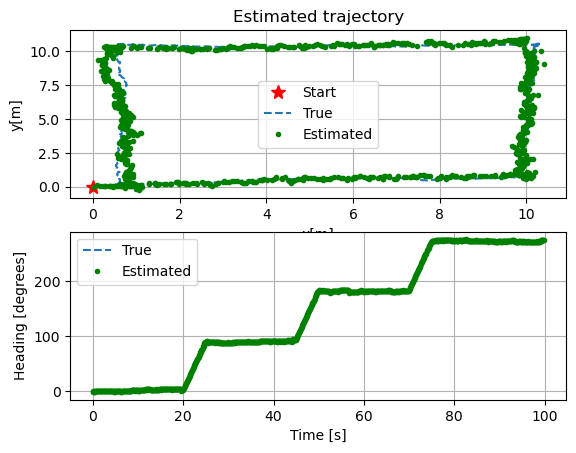

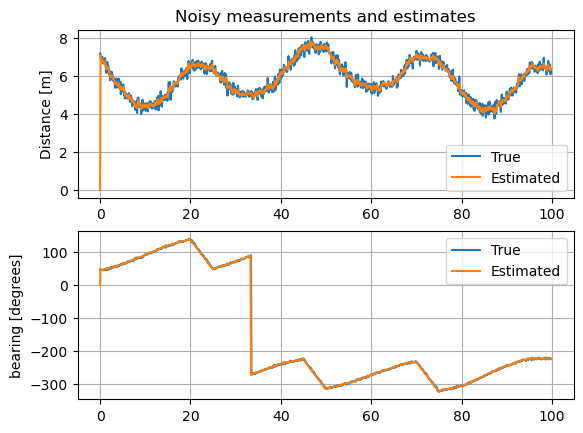

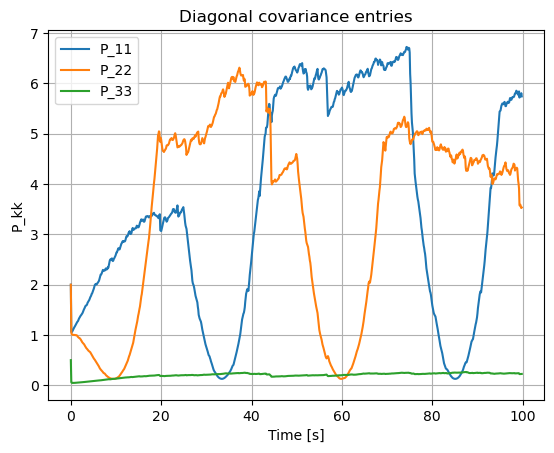

In [101]:
plt.figure(1)
plt.subplot(211)
plt.plot(x[0, 0], x[1, 0], '*r', markersize=10)
plt.plot(x[0, :], x[1, :], '--')
plt.plot(xhat[0, :], xhat[1, :], '.g')
plt.legend(["Start", "True", "Estimated"])
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.grid(True)
plt.title("Estimated trajectory")

plt.subplot(212)
plt.plot(np.arange(N-1)*Ts, x[2, :-1]/np.pi*180, '--')
plt.plot(np.arange(N-1)*Ts, xhat[2, :]/np.pi*180, '.g')
plt.legend([ "True", "Estimated"])
plt.xlabel("Time [s]")
plt.ylabel("Heading [degrees]")
plt.grid(True)

plt.figure(2)
plt.subplot(211)
plt.plot(np.arange(N-1)*Ts, y[0,:])
plt.plot(np.arange(N-1)*Ts, yHat[0,:])
plt.legend(["True", "Estimated"])
plt.ylabel("Distance [m]")
plt.title("Noisy measurements and estimates")
plt.grid(True)

plt.subplot(212)
plt.plot(np.arange(N-1)*Ts, y[1,:]/np.pi*180)
plt.plot(np.arange(N-1)*Ts, yHat[1,:]/np.pi*180)
plt.legend(["True", "Estimated"])
plt.ylabel("bearing [degrees]")
plt.grid(True)


plt.figure(3)
plt.plot(np.arange(N-1)*Ts, P[0, 0, :])
plt.plot(np.arange(N-1)*Ts, P[1, 1, :])
plt.plot(np.arange(N-1)*Ts, P[2, 2, :])
plt.xlabel("Time [s]")
plt.ylabel("P_kk")
plt.title("Diagonal covariance entries")
plt.legend(["P_11", "P_22", "P_33"])
plt.grid(True)


plt.show()
